# Deep mutational scanning of ZIKV E protein NS5
Mutational antigenic profiling of ZIKV E from the MR766 strain.
Experiments performed by Blake Richardson and Matt Evans.
Analysis by [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

The NS5 mutagensis was performed in "tiles" along the length of the gene.
The generated virus was then grown +/- IFN.

## Set up for analysis
Import Python packages and modules:

In [1]:
import glob
import os

import Bio.SeqIO

import dms_tools2
from dms_tools2 import AAS
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
import dms_tools2.prefs
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML

import pandas as pd

Using dms_tools2 2.6.7


Specify configuration for analysis:

In [2]:
use_existing = 'yes' # use existing output

ncpus = 8  # max CPUs to use

# directories
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

Input data found in the [./data/](data) directory:

In [3]:
refseqfile = './data/tile_1_amplicon.fasta'  # sequence of wildtype gene
samplelist = './data/samplelist.csv'  # samples sequenced
alignspecsfile = './data/subamplicon_alignspecs.txt'  # alignment specifications

Read in the wildtype (reference) sequence and its protein translation:

In [4]:
refseqrecord = Bio.SeqIO.read(refseqfile, 'fasta')
refprot = str(refseqrecord.seq.translate())
refseq = str(refseqrecord.seq)

print(f"Read wildtype (reference) sequence of {len(refseq)} nucleotides "
      f"that translates to protein of {len(refprot)} amino acids.")

Read wildtype (reference) sequence of 333 nucleotides that translates to protein of 111 amino acids.


## Process deep sequencing data
We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

First, we read in the samples:

In [5]:
samples = (pd.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection)
           )

display(HTML(samples.to_html(index=False)))

library,selection,R1,SRA_accession,name
wt,plasmid,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-WT-plasmid_S5_L001_R1_001.fastq.gz,NaN,wt-plasmid
lib1,plasmid,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib1-plasmid_S6_L001_R1_001.fastq.gz,NaN,lib1-plasmid
lib2,plasmid,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib2-plasmid_S7_L001_R1_001.fastq.gz,NaN,lib2-plasmid
lib3,plasmid,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib3-plasmid_S8_L001_R1_001.fastq.gz,NaN,lib3-plasmid
wt,no-IFN,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-WT-No-IFN_S9_L001_R1_001.fastq.gz,NaN,wt-no-IFN
lib1,no-IFN,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib1-No-IFN_S10_L001_R1_001.fastq.gz,NaN,lib1-no-IFN
lib2,no-IFN,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib2-No-IFN_S11_L001_R1_001.fastq.gz,NaN,lib2-no-IFN
lib3,no-IFN,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib3-No-IFN_S12_L001_R1_001.fastq.gz,NaN,lib3-no-IFN
wt,IFN-20-U-ml,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-WT-Yes-IFN_S13_L001_R1_001.fastq.gz,NaN,wt-IFN-20-U-ml
lib1,IFN-20-U-ml,/shared/ngs/illumina/bloom_lab/201112_M04866_0426_000000000-JBYVJ_new-demux/Data/Intensities/BaseCalls/BR-Lib1-Yes-IFN_S14_L001_R1_001.fastq.gz,NaN,lib1-IFN-20-U-ml


Now we read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [6]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()
print(alignspecs)

1,333,30,30


Now we use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [7]:
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 200 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts)), '\n'.join(log)

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in ./results/codoncounts


Now we look at the plots.
They will all have the following prefix:

In [8]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')

First, we look at the number of reads and barcodes per sample.
Most reads align with high quality, but many of the barcodes don't have too few reads.
This indicates we need more sequencing depth given the number of unique molecules (barcodes) that were retained going from round 1 to round 2 of the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html).

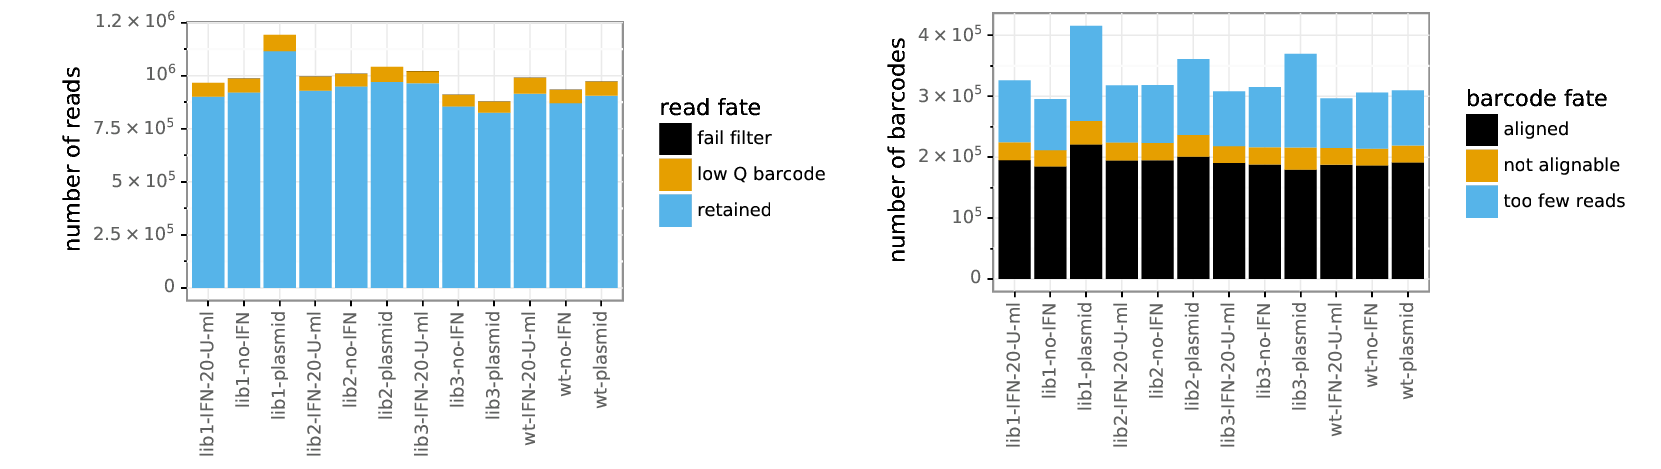

In [9]:
showPDF([bcsubamp_plot_prefix + 'readstats.pdf',
         bcsubamp_plot_prefix + 'bcstats.pdf'])

Next we look at number of reads per barcode.
Again, this shows that we need more sequencing depth, as most barcodes only have a single read, which prevents error correction using multiple reads per barcode:

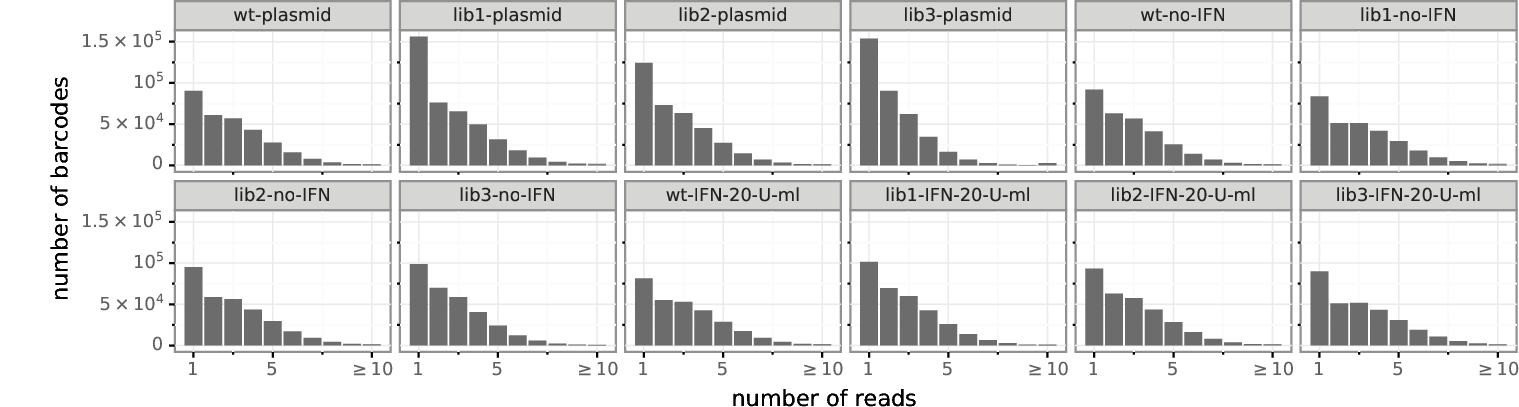

In [10]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

Now we look at the depth across the gene.
The depth is not uniform, suggesting that some subamplicons (particularly the second and third ones) were under-loaded relative to the other subamplicons:

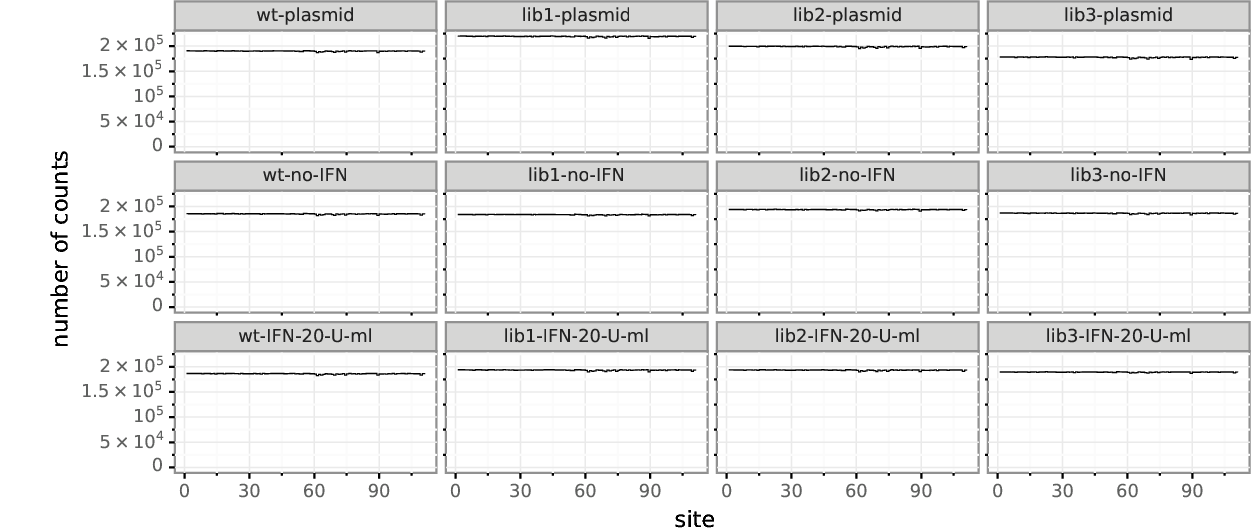

In [11]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

Here are the mutation frequencies across the gene.
As expected, the library plasmids have higher mutation rates than the wildtype control:

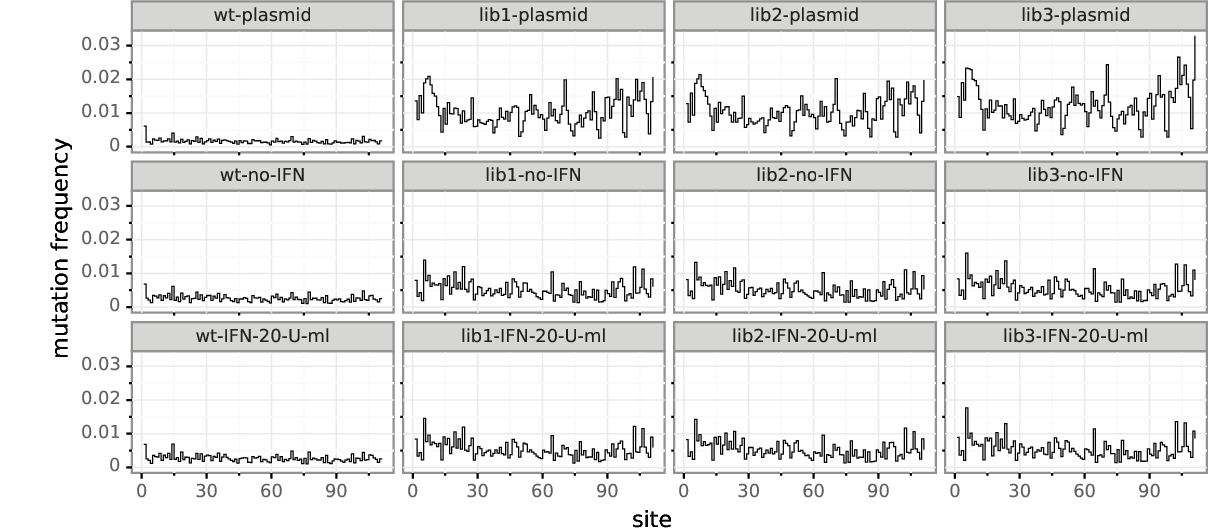

In [12]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

Here are the overall per-codon mutation rate averages:

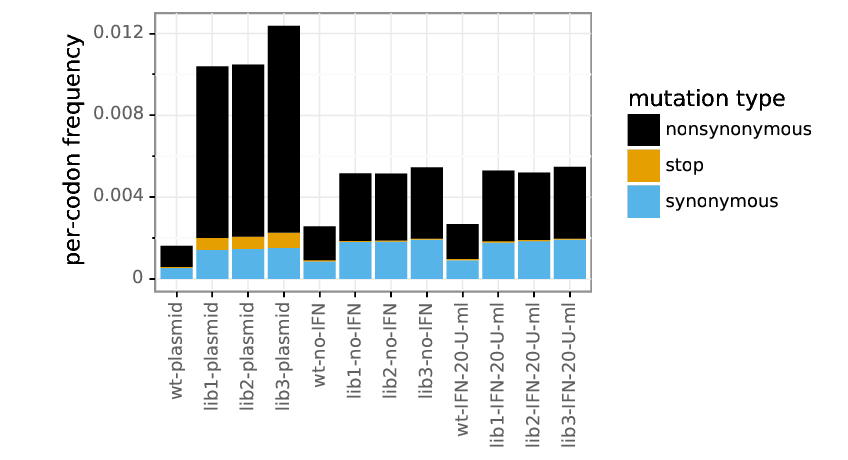

In [13]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

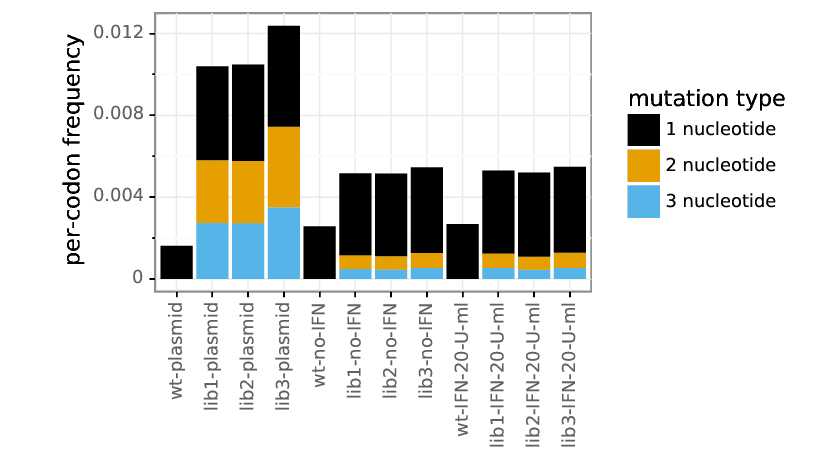

In [14]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes.
There is no massive over-representation of any class as would be expected if oxidative damage, which leads to `C->A` or `G->T` mutations:

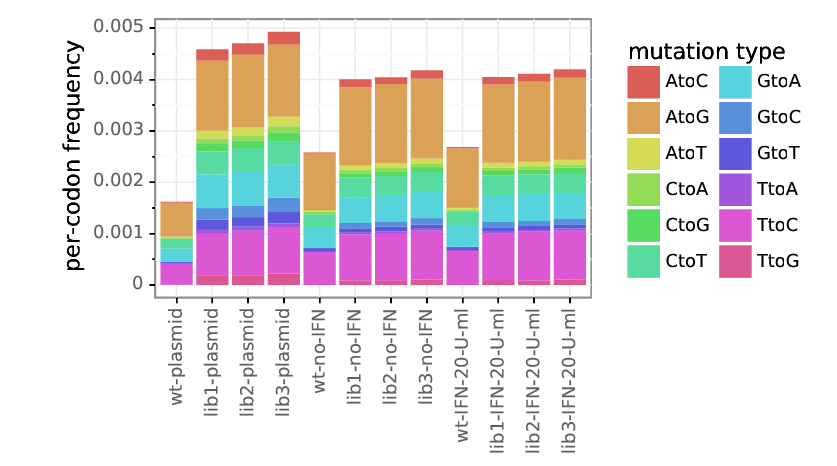

In [15]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

Finally, we look at mutation sampling.
We can see that most possible mutations are sampled very well in the plasmid samples, although the overall coverage is still pretty low so some are missed:

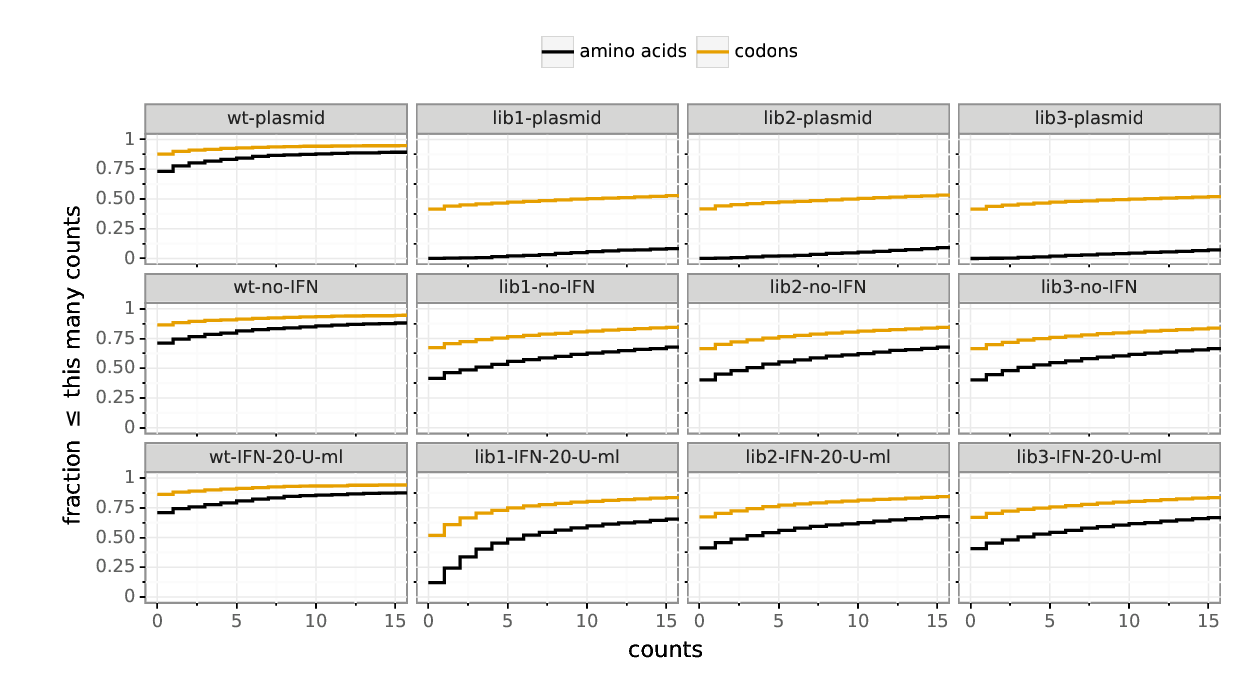

In [16]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')